In [1]:
from binance.client import Client as bnb_client
from datetime import datetime
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import zscore

In [141]:
client = bnb_client(tld='US')

def get_data(symbol,freq,start_ts = '2025-01-01',end_ts='2025-07-15'):
    data = client.get_historical_klines(symbol,freq,start_ts,end_ts)
    columns = ['open_time','open','high','low','close','volume','close_time','quote_volume',
    'num_trades','taker_base_volume','taker_quote_volume','ignore']

    data = pd.DataFrame(data,columns = columns)
    
    # Convert from POSIX timestamp (number of millisecond since jan 1, 1970)
    data['open_time'] = data['open_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
    data['close_time'] = data['close_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
    return data

In [129]:
universe = ['BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'SOLUSDT', 'ADAUSDT', 
            'XRPUSDT', 'MATICUSDT', 'DOGEUSDT']
freq = '4h'


px = {}
for x in universe:
    data = get_data(x,freq)
    px[x] = data.set_index('open_time')['close']

px = pd.DataFrame(px).astype(float)
px = px.reindex(pd.date_range(px.index[0],px.index[-1],freq=freq))
ret = px.pct_change()

In [130]:
returns = ret.stack().rename("return").reset_index()
returns['month'] = returns['level_0'].dt.month
returns['day'] = returns['level_0'].dt.day
returns['weekday'] = returns['level_0'].dt.dayofweek  # 0 = Monday
returns['hour'] = returns['level_0'].dt.hour
returns

,level_0,level_1,return,month,day,weekday,hour
0,2020-07-15 04:00:00,BTCUSDT,-0.000344,7,15,2,4
1,2020-07-15 04:00:00,ETHUSDT,-0.001668,7,15,2,4
2,2020-07-15 04:00:00,BNBUSDT,-0.012573,7,15,2,4
3,2020-07-15 04:00:00,ADAUSDT,-0.024168,7,15,2,4
4,2020-07-15 04:00:00,XRPUSDT,-0.005882,7,15,2,4
...,...,...,...,...,...,...,...
84016,2025-07-15 00:00:00,SOLUSDT,-0.018974,7,15,1,0
84017,2025-07-15 00:00:00,ADAUSDT,-0.022458,7,15,1,0
84018,2025-07-15 00:00:00,XRPUSDT,-0.036904,7,15,1,0
84019,2025-07-15 00:00:00,MATICUSDT,0.000000,7,15,1,0


<AxesSubplot:title={'center':'Average Return by Month'}, xlabel='month', ylabel='Avg Return'>

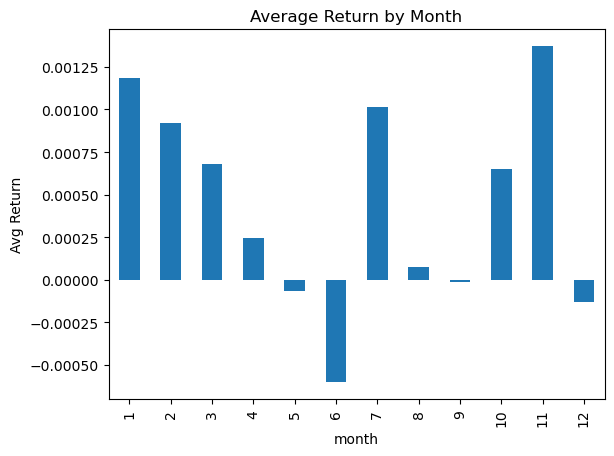

In [131]:
monthly_avg = returns.groupby('month')['return'].mean()
monthly_avg.plot(kind='bar', title="Average Return by Month", ylabel='Avg Return')

<AxesSubplot:title={'center':'Avg Return by Day of Week'}, xlabel='weekday', ylabel='Avg Return'>

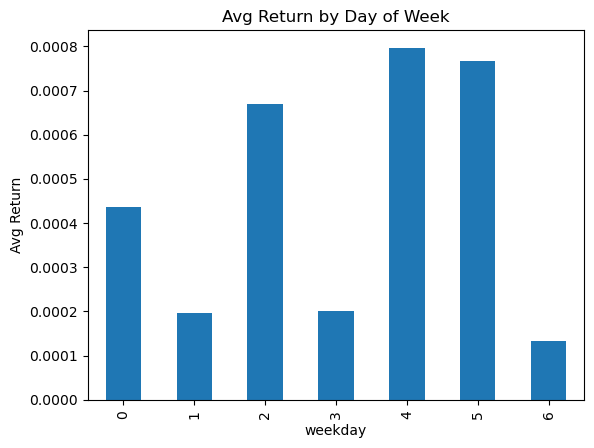

In [21]:
dow_avg = returns.groupby('weekday')['return'].mean()
dow_avg.plot(kind='bar', title="Avg Return by Day of Week", ylabel='Avg Return')


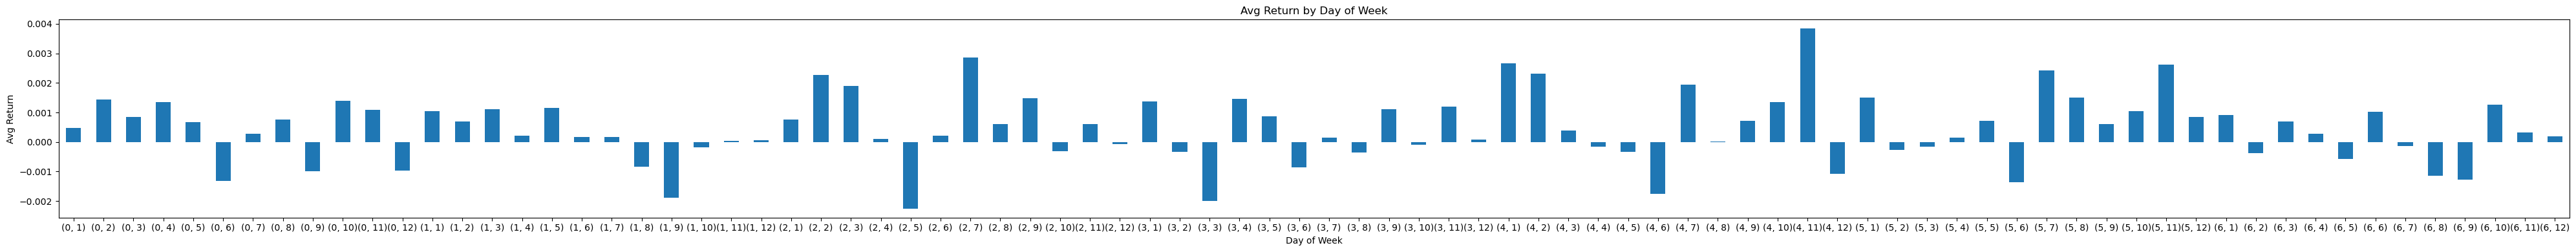

In [48]:
dow_avg = returns.groupby(['weekday','month'])['return'].mean()
plt.figure(figsize=(40, 4))
dow_avg.plot(kind='bar')
plt.title("Avg Return by Day of Week")
plt.ylabel("Avg Return")
plt.xlabel("Day of Week")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [62]:
# Define good months and weekdays
good_months = [1, 7, 11]
good_weekdays = [0, 2, 4, 5]
good_hours = [4,20]

# Apply mask
mask = returns['month'].isin(good_months) & returns['weekday'].isin(good_weekdays)
filtered_df = returns[mask]


# Calculate mean return
mean_filtered = filtered_df['return'].mean()
mean_all = returns['return'].mean()

mean_filtered/filtered_df['return'].std()*np.sqrt(365*24/4)

2.90027672918343

In [56]:
# Long on bad months (not as good)

returns['position'] = 0

# Long in good months & good weekdays
returns.loc[
    (returns['month'].isin(good_months)) & (returns['weekday'].isin(good_weekdays)),
    'position'
] = 1

# Short in bad months & good weekdays
returns.loc[
    (returns['month'].isin(bad_months)) & (returns['weekday'].isin(good_weekdays)),
    'position'
] = -1

# Strategy return
returns['strategy_return'] = returns['position'] * returns['return']
returns['strategy_return'].mean()/returns['strategy_return'].std()*np.sqrt(365*24/4)

1.2342457112860163

In [142]:
universe = ['BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'SOLUSDT', 'ADAUSDT', 
            'XRPUSDT', 'MATICUSDT', 'DOGEUSDT']
freq = '1d'


px = {}
for x in universe:
    data = get_data(x,freq)
    px[x] = data.set_index('open_time')['close']

px = pd.DataFrame(px).astype(float)
px = px.reindex(pd.date_range(px.index[0],px.index[-1],freq=freq))
ret2 = px.pct_change()

In [143]:
returns = ret2.stack().rename("return").reset_index()
returns['month'] = returns['level_0'].dt.month
returns['day'] = returns['level_0'].dt.day
returns['weekday'] = returns['level_0'].dt.dayofweek  # 0 = Monday
returns['hour'] = returns['level_0'].dt.hour
returns

,level_0,level_1,return,month,day,weekday,hour
0,2025-01-02,BTCUSDT,0.022748,1,2,3,0
1,2025-01-02,ETHUSDT,0.027623,1,2,3,0
2,2025-01-02,BNBUSDT,-0.004702,1,2,3,0
3,2025-01-02,SOLUSDT,0.070936,1,2,3,0
4,2025-01-02,ADAUSDT,0.045988,1,2,3,0
...,...,...,...,...,...,...,...
1555,2025-07-15,SOLUSDT,0.010904,7,15,1,0
1556,2025-07-15,ADAUSDT,0.015108,7,15,1,0
1557,2025-07-15,XRPUSDT,-0.015700,7,15,1,0
1558,2025-07-15,MATICUSDT,0.000000,7,15,1,0


In [147]:
returns['position'] = 0

In [149]:


#  & (returns['weekday'].isin(good_weekdays)

good_months = [1, 7, 11]
good_weekdays = [4,5]


returns.loc[(returns['weekday'].isin(good_weekdays) & (returns['weekday'].isin(good_weekdays))),
    'position'
] = 1

xrp = returns[returns['level_1'] == 'XRPUSDT']

returns['strategy_return'] = returns['position'] * returns['return'] * 365


returns['strategy_return'].mean()/returns['strategy_return'].std()*np.sqrt(365*24/4)


returns['strategy_return'].mean()*365




70.4627133597576

In [138]:
px['XRPUSDT'].mean() / px['XRPUSDT'].std()*np.sqrt(365*24/4)

54.853702171864754

In [117]:
px

,BTCUSDT,ETHUSDT,BNBUSDT,SOLUSDT,ADAUSDT,XRPUSDT,MATICUSDT,DOGEUSDT
2024-07-15,64588.45,3475.01,582.70,158.92,0.4440,0.5362,0.5481,0.12449
2024-07-16,65029.30,3443.28,573.80,160.37,0.4376,0.5787,0.5393,0.12483
2024-07-17,64130.63,3389.90,567.10,155.32,0.4361,0.6257,0.5390,0.12176
2024-07-18,63997.25,3429.92,569.10,158.97,0.4234,0.5698,0.5155,0.11959
2024-07-19,66659.40,3506.09,593.10,169.17,0.4383,0.5738,0.5349,0.12553
...,...,...,...,...,...,...,...,...
2025-07-11,117426.49,2959.04,690.20,162.87,0.7103,2.7324,NaN,0.20118
2025-07-12,117393.39,2940.46,684.30,160.66,0.7090,2.7394,NaN,0.19770
2025-07-13,119098.77,2973.37,691.22,161.42,0.7385,2.8377,NaN,0.19815
2025-07-14,119878.79,3012.74,688.06,162.33,0.7347,2.9617,NaN,0.19713
